In [1]:
## Load Environment

import pandas as pd
import numpy as np
import csv
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.util as cutil
import cartopy.feature as cfeature
import xesmf as xe
import cftime 
#import Ngl
import cartopy
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import regionmask
import warnings

In [2]:
## for visualization
warnings.filterwarnings('ignore')

### Open Data Files & Read in Variables

In [3]:
Path2 = '/glade/u/home/lizb/Tdep/Data_PMOC/'
exp2 = 'PlioB17_ciso_T31_gx3v7_branch'
PMOC=xr.open_mfdataset(Path2+exp2+'*_timeseries.nc')

Path3 = '/glade/u/home/lizb/Tdep/Data_PI/'
exp3 = 'PreInd_ciso_T31_gx3v7'
PI=xr.open_mfdataset(Path3+exp3+'*_timeseries6.nc')

In [4]:
PMOC_temp = PMOC.TEMP
PMOC_d13C = PMOC.CISO_DIC_d13C
PI_temp = PI.TEMP
PI_d13C = PI.CISO_DIC_d13C
basin_mask = PMOC.REGION_MASK

### Apply Basin Mask for Pacific

In [5]:
PMOC_temp_Pac = PMOC_temp.where((basin_mask>1) & (basin_mask<3))
PMOC_d13C_Pac = PMOC_d13C.where((basin_mask>1) & (basin_mask<3))

PI_temp_Pac = PI_temp.where((basin_mask>1) & (basin_mask<3))
PI_d13C_Pac = PI_d13C.where((basin_mask>1) & (basin_mask<3))

### Take Time Avg & Regrid to 1x1

In [6]:
PMOC_temp_Pac_time_avg=PMOC_temp_Pac.mean(dim='time').compute()
PMOC_d13C_Pac_time_avg=PMOC_d13C_Pac.mean(dim='time').compute()

PI_temp_Pac_time_avg=PI_temp_Pac.mean(dim='time').compute()
PI_d13C_Pac_time_avg=PI_d13C_Pac.mean(dim='time').compute()

In [7]:
## Rename Axes
PMOC_temp_Pac_time_avg=PMOC_temp_Pac_time_avg.rename({'TLONG': 'lon', 'TLAT': 'lat'})
PMOC_d13C_Pac_time_avg=PMOC_d13C_Pac_time_avg.rename({'TLONG': 'lon', 'TLAT': 'lat'})

## Create new grid
new_lat=np.arange(-89.5,90.5,1)
new_lon=np.arange(0.5,360,1)

ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                    'lon': (['lon'], new_lon)})

## Regrid
regridder = xe.Regridder(PMOC_temp_Pac_time_avg, ds_out,'nearest_s2d')
PMOC_temp_Pac_time_avg_reg = regridder(PMOC_temp_Pac_time_avg)

regridder = xe.Regridder(PMOC_d13C_Pac_time_avg, ds_out,'nearest_s2d')
PMOC_d13C_Pac_time_avg_reg = regridder(PMOC_d13C_Pac_time_avg)

In [8]:
## Rename Axes
PI_temp_Pac_time_avg=PI_temp_Pac_time_avg.rename({'TLONG': 'lon', 'TLAT': 'lat'})
PI_d13C_Pac_time_avg=PI_d13C_Pac_time_avg.rename({'TLONG': 'lon', 'TLAT': 'lat'})

## Create new grid
new_lat=np.arange(-89.5,90.5,1)
new_lon=np.arange(0.5,360,1)

ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                    'lon': (['lon'], new_lon)})

## Regrid
regridder = xe.Regridder(PI_temp_Pac_time_avg, ds_out,'nearest_s2d')
PI_temp_Pac_time_avg_reg = regridder(PI_temp_Pac_time_avg)

regridder = xe.Regridder(PI_d13C_Pac_time_avg, ds_out,'nearest_s2d')
PI_d13C_Pac_time_avg_reg = regridder(PI_d13C_Pac_time_avg)

### Load Proxy Data

In [9]:
## import Carbon Proxy data from a .csv using pandas

path = '/glade/u/home/lizb/Tdep/Data_csv/'
WP_sacc = pd.read_csv(path+"Western_Pac_sacc_Data_for_Python_Plots.csv",header=0,error_bad_lines=False, sep=',')
WP_tum = pd.read_csv(path+"Western_Pac_tumida_Data_for_Python_Plots.csv",header=0,error_bad_lines=False, sep=',')
WP_wuell = pd.read_csv(path+"Western_Pac_wuell_Data_for_Python_Plots.csv",header=0,error_bad_lines=False, sep=',')
EqPac_sacc = pd.read_csv(path+"Eq_Pac_sacc_Data_for_Python_Plots.csv",header=0,error_bad_lines=False, sep=',')
EqPac_tum = pd.read_csv(path+"Eq_Pac_tumida_Data_for_Python_Plots.csv",header=0,error_bad_lines=False, sep=',')
EqPac_wuell = pd.read_csv(path+"Eq_Pac_wuell_Data_for_Python_Plots.csv",header=0,error_bad_lines=False, sep=',')

EqPac_TEMP = pd.read_csv(path+"Eq_Pac_TEMP_DEPTH_Data_for_Python_Plots.csv",header=0,error_bad_lines=False, sep=',')
WP_TEMP = pd.read_csv(path+"Western_Pac_TEMP_Data_for_Python_Plots.csv",header=0,error_bad_lines=False, sep=',')

In [10]:
## Establish Dataframes

data1 = WP_sacc.values[:,:]
data2 = WP_tum.values[:,:]
data5 = WP_wuell.values[:,:]

data3 = EqPac_sacc.values[:,:]
data4 = EqPac_tum.values[:,:]
data6 = EqPac_wuell.values[:,:]

data8 = WP_TEMP.values[:,:]
data9 = EqPac_TEMP.values[:,:]

In [11]:
## Change Dataframes to Dataarrays

## Western Pacific
WP_temp_Lat = np.asarray(data8[:,0],dtype=np.float64)
WP_temp_Lon = np.asarray(data8[:,1],dtype=np.float64)
WP_temp_zt = np.asarray(data8[:,2],dtype=np.float64)
WP_temp_temp = np.asarray(data8[:,3],dtype=np.float64)

WP_sacc_Lat = np.asarray(data1[:,0],dtype=np.float64)
WP_sacc_Lon = np.asarray(data1[:,1],dtype=np.float64)
WP_sacc_zt = np.asarray(data1[:,2],dtype=np.float64)
WP_sacc_d13C = np.asarray(data1[:,3],dtype=np.float64)

WP_tum_Lat = np.asarray(data2[:,0],dtype=np.float64)
WP_tum_Lon = np.asarray(data2[:,1],dtype=np.float64)
WP_tum_zt = np.asarray(data2[:,2],dtype=np.float64)
WP_tum_d13C = np.asarray(data2[:,3],dtype=np.float64)

WP_wuell_Lat = np.asarray(data5[:,0],dtype=np.float64)
WP_wuell_Lon = np.asarray(data5[:,1],dtype=np.float64)
WP_wuell_zt = np.asarray(data5[:,2],dtype=np.float64)
WP_wuell_d13C = np.asarray(data5[:,3],dtype=np.float64)

## Equatorial Pacific
Eq_Pac_temp_Lat = np.asarray(data9[:,0],dtype=np.float64)
Eq_Pac_temp_Lon = np.asarray(data9[:,1],dtype=np.float64)
Eq_Pac_temp_zt = np.asarray(data9[:,2],dtype=np.float64)
Eq_Pac_temp_temp = np.asarray(data9[:,3],dtype=np.float64)

Eq_Pac_sacc_Lat = np.asarray(data3[:,0],dtype=np.float64)
Eq_Pac_sacc_Lon = np.asarray(data3[:,1],dtype=np.float64)
Eq_Pac_sacc_zt = np.asarray(data3[:,2],dtype=np.float64)
Eq_Pac_sacc_d13C = np.asarray(data3[:,3],dtype=np.float64)

Eq_Pac_tum_Lat = np.asarray(data4[:,0],dtype=np.float64)
Eq_Pac_tum_Lon = np.asarray(data4[:,1],dtype=np.float64)
Eq_Pac_tum_zt = np.asarray(data4[:,2],dtype=np.float64)
Eq_Pac_tum_d13C = np.asarray(data4[:,3],dtype=np.float64)

Eq_Pac_wuell_Lat = np.asarray(data6[:,0],dtype=np.float64)
Eq_Pac_wuell_Lon = np.asarray(data6[:,1],dtype=np.float64)
Eq_Pac_wuell_zt = np.asarray(data6[:,2],dtype=np.float64)
Eq_Pac_wuell_d13C = np.asarray(data6[:,3],dtype=np.float64)

### Take the Zonal Average ~120-165E

In [12]:
## Clip Data for Zonal Extent

PMOC_temp_Western_Pac_time_avg_reg = PMOC_temp_Pac_time_avg_reg[:,:,120:165]
PMOC_d13C_Western_Pac_time_avg_reg = PMOC_d13C_Pac_time_avg_reg[:,:,120:165]

In [13]:
PI_temp_Western_Pac_time_avg_reg = PI_temp_Pac_time_avg_reg[:,:,120:165]
PI_d13C_Western_Pac_time_avg_reg = PI_d13C_Pac_time_avg_reg[:,:,120:165]

In [14]:
## Calculate Zonal Mean

PMOC_temp_Western_Pac_time_avg_reg_ZM=np.nanmean(PMOC_temp_Western_Pac_time_avg_reg, axis=2)
PMOC_d13C_Western_Pac_time_avg_reg_ZM=np.nanmean(PMOC_d13C_Western_Pac_time_avg_reg, axis=2)

In [15]:
PI_temp_Western_Pac_time_avg_reg_ZM=np.nanmean(PI_temp_Western_Pac_time_avg_reg, axis=2)
PI_d13C_Western_Pac_time_avg_reg_ZM=np.nanmean(PI_d13C_Western_Pac_time_avg_reg, axis=2)

### Western Pacific Zonal Mean Temp & d13C Anomaly

In [16]:
## Calculate Anomaly

WPAC_TEMP_Anomaly = PMOC_temp_Western_Pac_time_avg_reg_ZM - PI_temp_Western_Pac_time_avg_reg_ZM
WPAC_d13C_Anomaly = PMOC_d13C_Western_Pac_time_avg_reg_ZM - PI_d13C_Western_Pac_time_avg_reg_ZM

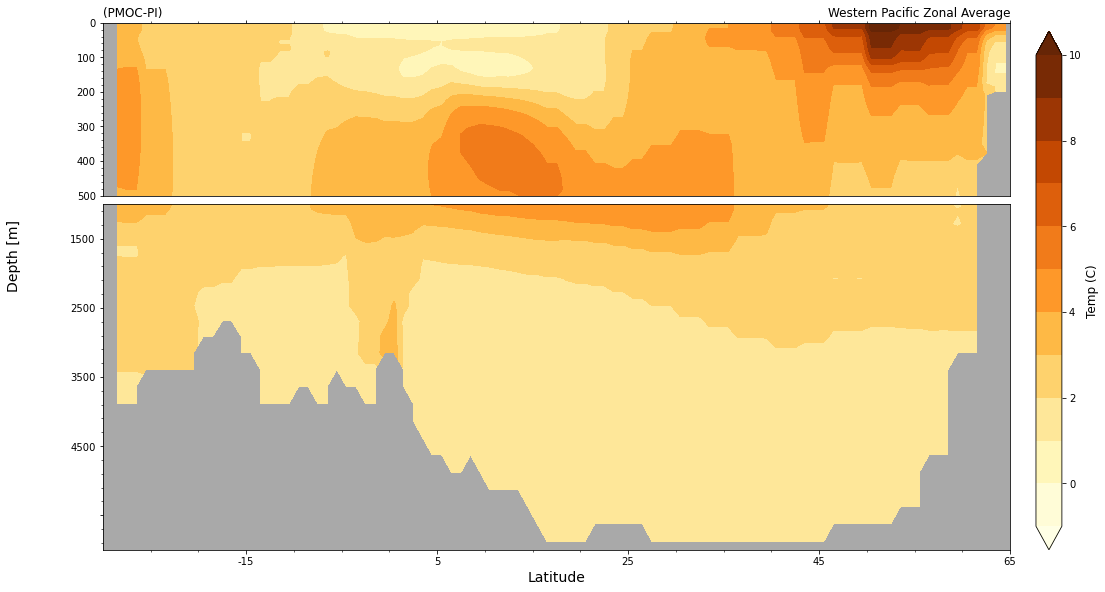

In [17]:
lo = -1.0
hi = 10.0
dc = 1.0
cnlevels = np.arange(lo, hi+dc, dc)

## create a figure object
fig = plt.figure(figsize=(18, 12))

## add two axes
ax1 = fig.add_axes([0.1, 0.51, 0.7, 0.2]) # top 500 m
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.4]) # deep ocean

## set the background color for land
ax1.set_facecolor('darkgray')
ax2.set_facecolor('darkgray')

## plot the model d13C by looping over axes
cs = [None]*2
mesh = [None]*2  
for i, ax in enumerate([ax1, ax2]):
    mesh[i] = ax.contourf(PMOC_temp_Pac_time_avg_reg.lat,PMOC_temp_Pac_time_avg_reg.z_t*1e-2,
                          WPAC_TEMP_Anomaly,levels=cnlevels,cmap='YlOrBr',extend='both')  
    
## set axis limits, note the reversed limits reverse the y-axis
ax1.set_ylim([500., 0.])
ax2.set_ylim([5500., 500.])
ax1.set_xlim([-35, 60])
ax2.set_xlim([-35, 60])
    
## set top axis properties
ax1.minorticks_on()
ax1.set_xticklabels([])
ax1.xaxis.set_ticks_position('top')

## set bottom axis properties
ax2.minorticks_on()
ax2.xaxis.set_ticks_position('bottom')
ax2.set_xticklabels(np.arange(-35,70,20))  
ax2.set_yticklabels(np.arange(500,5500,1000))

## set plot-level axis labels via ax2
ax2.set_ylabel('Depth [m]',fontsize=14)
ax2.yaxis.set_label_coords(-0.09, 0.85)  
ax2.set_xlabel('Latitude',fontsize=14)
    
## set colorbar properties    
colorbar_axes = plt.gcf().add_axes([0.82, 0.1, 0.02, 0.6])
colorbar = plt.colorbar(mesh[i], colorbar_axes, orientation='vertical')
colorbar.set_label('%s' % 'Temp (C)',size=12)

## title
ax1.set_title('(PMOC-PI)',loc='left')
ax1.set_title('Western Pacific Zonal Average',loc='right');

plt.rcParams['pdf.fonttype']=42
fig.savefig('Goldschmidt_TEMP_WPac_PMOC_PI_anomaly.pdf', dpi=300, bbox_inches='tight')

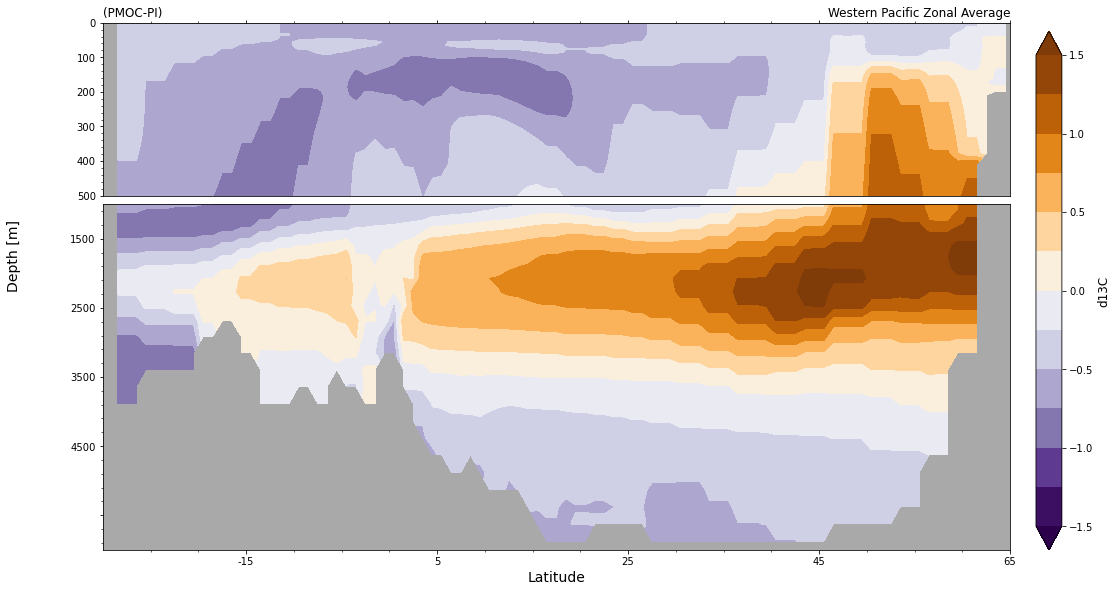

In [18]:
lo = -1.5
hi = 1.5
dc = 0.25
cnlevels = np.arange(lo, hi+dc, dc)

## create a figure object
fig = plt.figure(figsize=(18, 12))

## add two axes
ax1 = fig.add_axes([0.1, 0.51, 0.7, 0.2]) # top 500 m
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.4]) # deep ocean

## set the background color for land
ax1.set_facecolor('darkgray')
ax2.set_facecolor('darkgray')

## plot the model d13C by looping over axes
cs = [None]*2
mesh = [None]*2  
for i, ax in enumerate([ax1, ax2]):
    mesh[i] = ax.contourf(PMOC_temp_Pac_time_avg_reg.lat,PMOC_temp_Pac_time_avg_reg.z_t*1e-2,
                          WPAC_d13C_Anomaly,levels=cnlevels,cmap='PuOr_r',extend='both')  
    
## set axis limits, note the reversed limits reverse the y-axis
ax1.set_ylim([500., 0.])
ax2.set_ylim([5500., 500.])
ax1.set_xlim([-35, 60])
ax2.set_xlim([-35, 60])
    
## set top axis properties
ax1.minorticks_on()
ax1.set_xticklabels([])
ax1.xaxis.set_ticks_position('top')

## set bottom axis properties
ax2.minorticks_on()
ax2.xaxis.set_ticks_position('bottom')
ax2.set_xticklabels(np.arange(-35,70,20))  
ax2.set_yticklabels(np.arange(500,5500,1000))

## set plot-level axis labels via ax2
ax2.set_ylabel('Depth [m]',fontsize=14)
ax2.yaxis.set_label_coords(-0.09, 0.85)  
ax2.set_xlabel('Latitude',fontsize=14)
    
## set colorbar properties    
colorbar_axes = plt.gcf().add_axes([0.82, 0.1, 0.02, 0.6])
colorbar = plt.colorbar(mesh[i], colorbar_axes, orientation='vertical')
colorbar.set_label('%s' % 'd13C',size=12)

## title
ax1.set_title('(PMOC-PI)',loc='left')
ax1.set_title('Western Pacific Zonal Average',loc='right');

plt.rcParams['pdf.fonttype']=42
fig.savefig('Goldschmidt_d13C_WPac_PMOC_PI_anomaly.pdf', dpi=300, bbox_inches='tight')

### Western Pacific Zonal Mean data-model plots

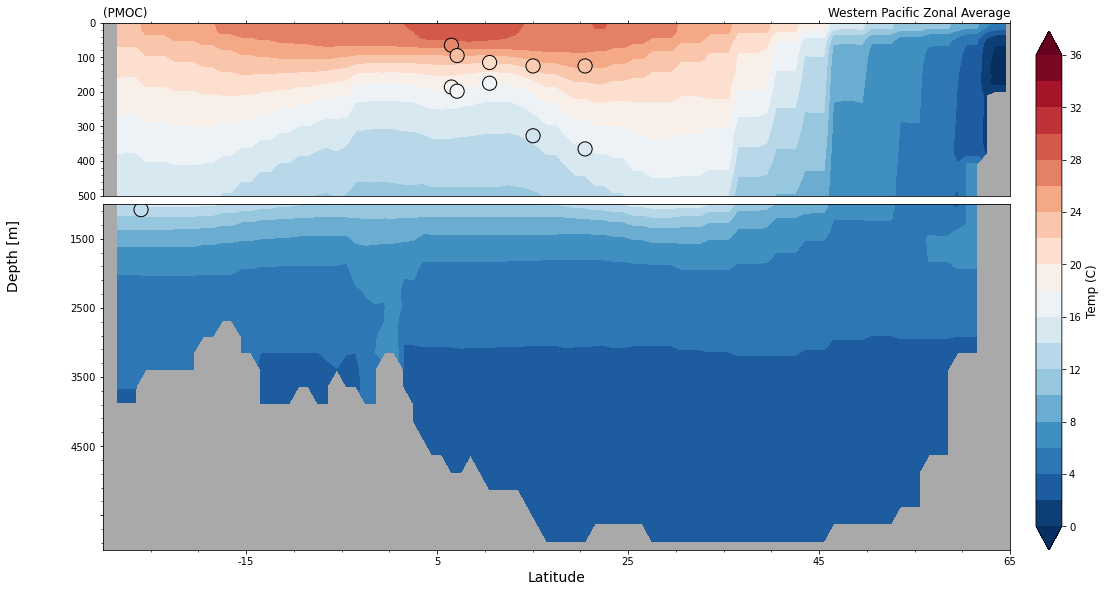

In [19]:
lo = 0.0
hi = 35.0
dc = 2.0
cnlevels = np.arange(lo, hi+dc, dc)

## create a figure object
fig = plt.figure(figsize=(18, 12))

## add two axes
ax1 = fig.add_axes([0.1, 0.51, 0.7, 0.2]) # top 500 m
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.4]) # deep ocean

## set the background color for land
ax1.set_facecolor('darkgray')
ax2.set_facecolor('darkgray')

## plot the model d13C by looping over axes
cs = [None]*2
mesh = [None]*2  
for i, ax in enumerate([ax1, ax2]):
    mesh[i] = ax.contourf(PMOC_temp_Pac_time_avg_reg.lat,PMOC_temp_Pac_time_avg_reg.z_t*1e-2,
                          PMOC_temp_Western_Pac_time_avg_reg_ZM,levels=cnlevels,cmap='RdBu_r',extend='both')  
    
## set axis limits, note the reversed limits reverse the y-axis
ax1.set_ylim([500., 0.])
ax2.set_ylim([5500., 500.])
ax1.set_xlim([-35, 60])
ax2.set_xlim([-35, 60])
    
## set top axis properties
ax1.minorticks_on()
ax1.set_xticklabels([])
ax1.xaxis.set_ticks_position('top')

## set bottom axis properties
ax2.minorticks_on()
ax2.xaxis.set_ticks_position('bottom')
ax2.set_xticklabels(np.arange(-35,70,20))  
ax2.set_yticklabels(np.arange(500,5500,1000))

## set plot-level axis labels via ax2
ax2.set_ylabel('Depth [m]',fontsize=14)
ax2.yaxis.set_label_coords(-0.09, 0.85)  
ax2.set_xlabel('Latitude',fontsize=14)
    
## set colorbar properties    
colorbar_axes = plt.gcf().add_axes([0.82, 0.1, 0.02, 0.6])
colorbar = plt.colorbar(mesh[i], colorbar_axes, orientation='vertical')
colorbar.set_label('%s' % 'Temp (C)',size=12)

## plot the sacculifer d13C proxy data by also looping over axes
cs = [None]*2
mesh2 = [None]*2
for i, ax in enumerate([ax1, ax2]):
    mesh2[i] = ax.scatter(WP_temp_Lat,WP_temp_zt,c=WP_temp_temp,vmin=min(cnlevels),vmax=max(cnlevels),marker='o',edgecolors='k',s=200, cmap='RdBu_r')

## title
ax1.set_title('(PMOC)',loc='left')
ax1.set_title('Western Pacific Zonal Average',loc='right');

plt.rcParams['pdf.fonttype']=42
fig.savefig('Goldschmidt_TEMP_WPac_Data_Model.pdf', dpi=300, bbox_inches='tight')

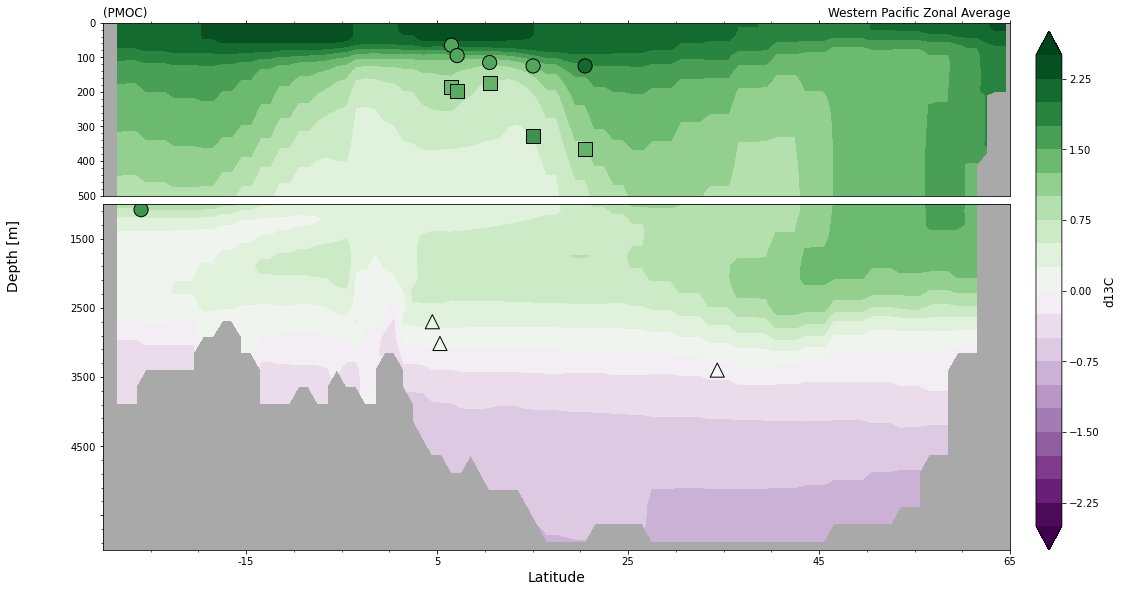

In [20]:
lo = -2.5
hi = 2.5
dc = 0.25
cnlevels = np.arange(lo, hi+dc, dc)

## create a figure object
fig = plt.figure(figsize=(18, 12))

## add two axes
ax1 = fig.add_axes([0.1, 0.51, 0.7, 0.2]) # top 250 m
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.4]) # deep ocean

## set the background color for land
ax1.set_facecolor('darkgray')
ax2.set_facecolor('darkgray')

## plot the model d13C by looping over axes
cs = [None]*2
mesh = [None]*2  
for i, ax in enumerate([ax1, ax2]):
    mesh[i] = ax.contourf(PMOC_d13C_Pac_time_avg_reg.lat,PMOC_d13C_Pac_time_avg_reg.z_t*1e-2,
                          PMOC_d13C_Western_Pac_time_avg_reg_ZM,levels=cnlevels,cmap='PRGn',extend='both')  
    
## set axis limits, note the reversed limits reverse the y-axis
ax1.set_ylim([500., 0.])
ax2.set_ylim([5500., 500.])
ax1.set_xlim([-35, 60])
ax2.set_xlim([-35, 60])
    
## set top axis properties
ax1.minorticks_on()
ax1.set_xticklabels([])
ax1.xaxis.set_ticks_position('top')

## set bottom axis properties
ax2.minorticks_on()
ax2.xaxis.set_ticks_position('bottom')
ax2.set_xticklabels(np.arange(-35,70,20))  
ax2.set_yticklabels(np.arange(500,5500,1000))

## set plot-level axis labels via ax2
ax2.set_ylabel('Depth [m]',fontsize=14)
ax2.yaxis.set_label_coords(-0.09, 0.85)  
ax2.set_xlabel('Latitude',fontsize=14)

## plot the sacculifer d13C proxy data by also looping over axes
cs = [None]*2
mesh2 = [None]*2
for i, ax in enumerate([ax1, ax2]):
    mesh2[i] = ax.scatter(WP_sacc_Lat,WP_sacc_zt,c=WP_sacc_d13C,vmin=min(cnlevels),vmax=max(cnlevels),marker='o',edgecolors='k',s=200, cmap='PRGn')

## plot the tumida d13C proxy data by also looping over axes
cs = [None]*2
mesh3 = [None]*2
for i, ax in enumerate([ax1, ax2]):
    mesh3[i] = ax.scatter(WP_tum_Lat,WP_tum_zt,c=WP_tum_d13C,vmin=min(cnlevels), vmax=max(cnlevels),marker='s',edgecolors='k',s=200, cmap='PRGn')

## plot the wuellerstorfi d13C proxy data by also looping over axes
cs = [None]*2
mesh4 = [None]*2
for i, ax in enumerate([ax1, ax2]):
    mesh4[i] = ax.scatter(WP_wuell_Lat,WP_wuell_zt,c=WP_wuell_d13C,vmin=min(cnlevels), vmax=max(cnlevels),marker='^',edgecolors='k',s=200, cmap='PRGn')
    
## set colorbar properties    
colorbar_axes = plt.gcf().add_axes([0.82, 0.1, 0.02, 0.6])
colorbar = plt.colorbar(mesh[i], colorbar_axes, orientation='vertical')
colorbar.set_label('%s' % 'd13C',size=12)

## title
ax1.set_title('(PMOC)',loc='left')
ax1.set_title('Western Pacific Zonal Average',loc='right');

plt.rcParams['pdf.fonttype']=42
fig.savefig('Goldschmidt_d13C_WPac_Data_Model_Birch_corrections_saccnottum.pdf', dpi=300, bbox_inches='tight')

# Equatorial Cross-Section Data-Model Plots

### time average and regrid to 1x1

In [21]:
## Time Averages

PMOC_temp_time_avg=PMOC_temp.mean(dim='time').compute()
PMOC_d13C_time_avg=PMOC_d13C.mean(dim='time').compute()

PI_temp_time_avg=PI_temp.mean(dim='time').compute()
PI_d13C_time_avg=PI_d13C.mean(dim='time').compute()

In [22]:
#### Regrid to 1x1

## Rename Axes
PMOC_temp_time_avg=PMOC_temp_time_avg.rename({'TLONG': 'lon', 'TLAT': 'lat'})
PMOC_d13C_time_avg=PMOC_d13C_time_avg.rename({'TLONG': 'lon', 'TLAT': 'lat'})

## Create new grid
new_lat=np.arange(-89.5,90.5,1)
new_lon=np.arange(0.5,360,1)

ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                    'lon': (['lon'], new_lon)})

## Regrid
regridder = xe.Regridder(PMOC_temp_time_avg, ds_out,'nearest_s2d')
PMOC_temp_time_avg_reg = regridder(PMOC_temp_time_avg)

regridder = xe.Regridder(PMOC_d13C_time_avg, ds_out,'nearest_s2d')
PMOC_d13C_time_avg_reg = regridder(PMOC_d13C_time_avg)

In [23]:
## Rename Axes
PI_temp_time_avg=PI_temp_time_avg.rename({'TLONG': 'lon', 'TLAT': 'lat'})
PI_d13C_time_avg=PI_d13C_time_avg.rename({'TLONG': 'lon', 'TLAT': 'lat'})

## Create new grid
new_lat=np.arange(-89.5,90.5,1)
new_lon=np.arange(0.5,360,1)

ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                    'lon': (['lon'], new_lon)})

## Regrid
regridder = xe.Regridder(PI_temp_time_avg, ds_out,'nearest_s2d')
PI_temp_time_avg_reg = regridder(PI_temp_time_avg)

regridder = xe.Regridder(PI_d13C_time_avg, ds_out,'nearest_s2d')
PI_d13C_time_avg_reg = regridder(PI_d13C_time_avg)

## Equatorial Slice - d13C Data-Model

In [24]:
PMOC_d13C_time_avg_reg_EqPac=PMOC_d13C_time_avg_reg.sel(lat=slice(-5,5))
PMOC_temp_time_avg_reg_EqPac=PMOC_temp_time_avg_reg.sel(lat=slice(-5,5))

PI_d13C_time_avg_reg_EqPac=PI_d13C_time_avg_reg.sel(lat=slice(-5,5))
PI_temp_time_avg_reg_EqPac=PI_temp_time_avg_reg.sel(lat=slice(-5,5))

In [25]:
## Calculate the average 5S to 5N

PMOC_temp_time_avg_reg_EqPac_ZM=np.nanmean(PMOC_temp_time_avg_reg_EqPac, axis=1)
PMOC_d13C_time_avg_reg_EqPac_ZM=np.nanmean(PMOC_d13C_time_avg_reg_EqPac, axis=1)

PI_temp_time_avg_reg_EqPac_ZM=np.nanmean(PI_temp_time_avg_reg_EqPac, axis=1)
PI_d13C_time_avg_reg_EqPac_ZM=np.nanmean(PI_d13C_time_avg_reg_EqPac, axis=1)

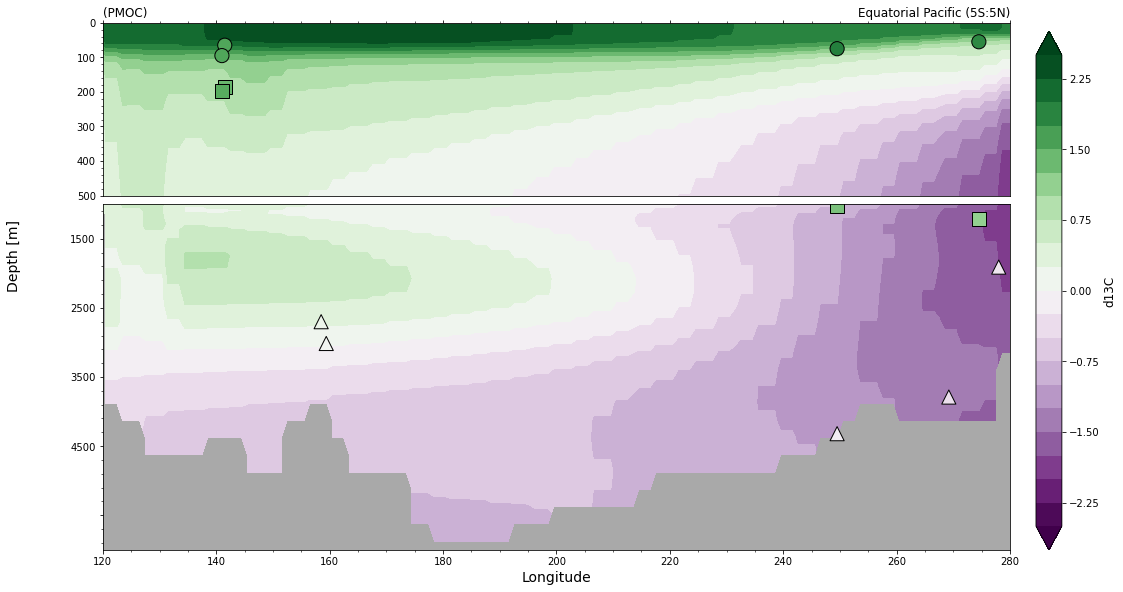

In [26]:
lo = -2.5
hi = 2.5
dc = 0.25
cnlevels = np.arange(lo, hi+dc, dc)

## create a figure object
fig = plt.figure(figsize=(18, 12))

## add two axes
ax1 = fig.add_axes([0.1, 0.51, 0.7, 0.2]) # top 500 m
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.4]) # deep ocean

## set the background color for land
ax1.set_facecolor('darkgray')
ax2.set_facecolor('darkgray')

## plot the model d13C by looping over axes
cs = [None]*2
mesh = [None]*2  
for i, ax in enumerate([ax1, ax2]):
    mesh[i] = ax.contourf(PMOC_d13C_time_avg_reg.lon,PMOC_d13C_time_avg_reg.z_t*1e-2,
                          PMOC_d13C_time_avg_reg_EqPac_ZM,levels=cnlevels,cmap='PRGn',extend='both')  
    
## set axis limits, note the reversed limits reverse the y-axis
ax1.set_ylim([500., 0.])
ax2.set_ylim([5500., 500.])
ax1.set_xlim([120, 280])
ax2.set_xlim([120, 280])
    
## set top axis properties
ax1.minorticks_on()
ax1.set_xticklabels([])
ax1.xaxis.set_ticks_position('top')

## set bottom axis properties
ax2.minorticks_on()
ax2.xaxis.set_ticks_position('bottom')
ax2.set_xticklabels(np.arange(120,300,20))  
ax2.set_yticklabels(np.arange(500,5500,1000))

## set plot-level axis labels via ax2
ax2.set_ylabel('Depth [m]',fontsize=14)
ax2.yaxis.set_label_coords(-0.09, 0.85)  
ax2.set_xlabel('Longitude',fontsize=14)

## plot the sacculifer d13C proxy data by also looping over axes
cs = [None]*2
mesh2 = [None]*2
for i, ax in enumerate([ax1, ax2]):
    mesh2[i] = ax.scatter(Eq_Pac_sacc_Lon,Eq_Pac_sacc_zt,c=Eq_Pac_sacc_d13C,vmin=min(cnlevels),vmax=max(cnlevels),marker='o',edgecolors='k',s=200, cmap='PRGn')

## plot the tumida d13C proxy data by also looping over axes
cs = [None]*2
mesh3 = [None]*2
for i, ax in enumerate([ax1, ax2]):
    mesh3[i] = ax.scatter(Eq_Pac_tum_Lon,Eq_Pac_tum_zt,c=Eq_Pac_tum_d13C,vmin=min(cnlevels), vmax=max(cnlevels),marker='s',edgecolors='k',s=200, cmap='PRGn')

## plot the wuellerstorfi d13C proxy data by also looping over axes
cs = [None]*2
mesh4 = [None]*2
for i, ax in enumerate([ax1, ax2]):
    mesh4[i] = ax.scatter(Eq_Pac_wuell_Lon,Eq_Pac_wuell_zt,c=Eq_Pac_wuell_d13C,vmin=min(cnlevels), vmax=max(cnlevels),marker='^',edgecolors='k',s=200, cmap='PRGn')
    
## set colorbar properties    
colorbar_axes = plt.gcf().add_axes([0.82, 0.1, 0.02, 0.6])
colorbar = plt.colorbar(mesh[i], colorbar_axes, orientation='vertical')
colorbar.set_label('%s' % 'd13C',size=12)

## title
ax1.set_title('(PMOC)',loc='left')
ax1.set_title('Equatorial Pacific (5S:5N)',loc='right');

plt.rcParams['pdf.fonttype']=42
fig.savefig('Goldschmidt_d13C_Eq_Pac_Data_Model_Birch_Carbon_corrections_saccnottum.pdf', dpi=300, bbox_inches='tight')

### Eq Pacific Anomaly Plots PMOC-PI

In [27]:
Eq_Pac_TEMP_Anomaly = PMOC_temp_time_avg_reg_EqPac_ZM - PI_temp_time_avg_reg_EqPac_ZM
Eq_Pac_d13C_Anomaly = PMOC_d13C_time_avg_reg_EqPac_ZM - PI_d13C_time_avg_reg_EqPac_ZM

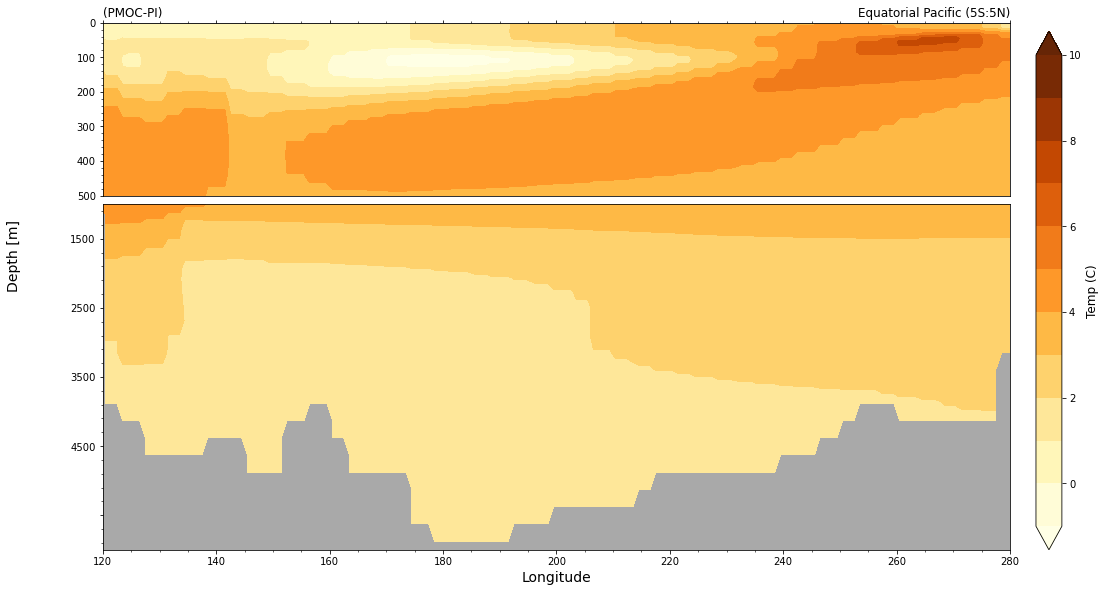

In [28]:
lo = -1.0
hi = 10.0
dc = 1.0
cnlevels = np.arange(lo, hi+dc, dc)

## create a figure object
fig = plt.figure(figsize=(18, 12))

## add two axes
ax1 = fig.add_axes([0.1, 0.51, 0.7, 0.2]) # top 500 m
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.4]) # deep ocean

## set the background color for land
ax1.set_facecolor('darkgray')
ax2.set_facecolor('darkgray')

## plot the model d13C by looping over axes
cs = [None]*2
mesh = [None]*2  
for i, ax in enumerate([ax1, ax2]):
    mesh[i] = ax.contourf(PMOC_d13C_time_avg_reg.lon,PMOC_d13C_time_avg_reg.z_t*1e-2,
                          Eq_Pac_TEMP_Anomaly,levels=cnlevels,cmap='YlOrBr',extend='both')  
    
## set axis limits, note the reversed limits reverse the y-axis
ax1.set_ylim([500., 0.])
ax2.set_ylim([5500., 500.])
ax1.set_xlim([120, 280])
ax2.set_xlim([120, 280])
    
## set top axis properties
ax1.minorticks_on()
ax1.set_xticklabels([])
ax1.xaxis.set_ticks_position('top')

## set bottom axis properties
ax2.minorticks_on()
ax2.xaxis.set_ticks_position('bottom')
ax2.set_xticklabels(np.arange(120,300,20))  
ax2.set_yticklabels(np.arange(500,5500,1000))

## set plot-level axis labels via ax2
ax2.set_ylabel('Depth [m]',fontsize=14)
ax2.yaxis.set_label_coords(-0.09, 0.85)  
ax2.set_xlabel('Longitude',fontsize=14)

## set colorbar properties    
colorbar_axes = plt.gcf().add_axes([0.82, 0.1, 0.02, 0.6])
colorbar = plt.colorbar(mesh[i], colorbar_axes, orientation='vertical')
colorbar.set_label('%s' % 'Temp (C)',size=12)

## title
ax1.set_title('(PMOC-PI)',loc='left')
ax1.set_title('Equatorial Pacific (5S:5N)',loc='right');

plt.rcParams['pdf.fonttype']=42
fig.savefig('Goldschmidt_temp_Eq_Pac_PMOC_PI_anomaly.pdf', dpi=300, bbox_inches='tight')

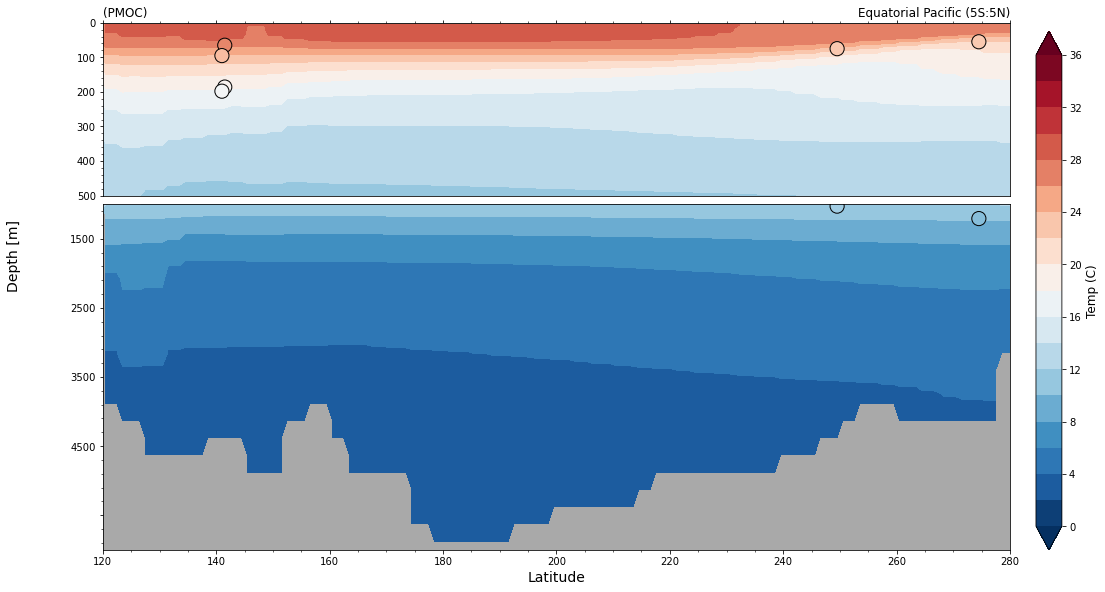

In [29]:
lo = 0.0
hi = 35.0
dc = 2.0
cnlevels = np.arange(lo, hi+dc, dc)

## create a figure object
fig = plt.figure(figsize=(18, 12))

## add two axes
ax1 = fig.add_axes([0.1, 0.51, 0.7, 0.2]) # top 500 m
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.4]) # deep ocean

## set the background color for land
ax1.set_facecolor('darkgray')
ax2.set_facecolor('darkgray')

## plot the model d13C by looping over axes
cs = [None]*2
mesh = [None]*2  
for i, ax in enumerate([ax1, ax2]):
    mesh[i] = ax.contourf(PMOC_temp_time_avg_reg.lon,PMOC_temp_time_avg_reg.z_t*1e-2,
                          PMOC_temp_time_avg_reg_EqPac_ZM,levels=cnlevels,cmap='RdBu_r',extend='both')  
    
## set axis limits, note the reversed limits reverse the y-axis
ax1.set_ylim([500., 0.])
ax2.set_ylim([5500., 500.])
ax1.set_xlim([120, 280])
ax2.set_xlim([120, 280])
    
## set top axis properties
ax1.minorticks_on()
ax1.set_xticklabels([])
ax1.xaxis.set_ticks_position('top')

## set bottom axis properties
ax2.minorticks_on()
ax2.xaxis.set_ticks_position('bottom')
ax2.set_xticklabels(np.arange(120,300,20))  
ax2.set_yticklabels(np.arange(500,5500,1000))

## set plot-level axis labels via ax2
ax2.set_ylabel('Depth [m]',fontsize=14)
ax2.yaxis.set_label_coords(-0.09, 0.85)  
ax2.set_xlabel('Latitude',fontsize=14)
    
## plot the sacculifer d13C proxy data by also looping over axes
cs = [None]*2
mesh2 = [None]*2
for i, ax in enumerate([ax1, ax2]):
    mesh2[i] = ax.scatter(Eq_Pac_temp_Lon,Eq_Pac_temp_zt,c=Eq_Pac_temp_temp,vmin=min(cnlevels),vmax=max(cnlevels),marker='o',edgecolors='k',s=200, cmap='RdBu_r')
    
## set colorbar properties    
colorbar_axes = plt.gcf().add_axes([0.82, 0.1, 0.02, 0.6])
colorbar = plt.colorbar(mesh[i], colorbar_axes, orientation='vertical')
colorbar.set_label('%s' % 'Temp (C)',size=12)

## title
ax1.set_title('(PMOC)',loc='left')
ax1.set_title('Equatorial Pacific (5S:5N)',loc='right');

plt.rcParams['pdf.fonttype']=42
fig.savefig('Goldschmidt_TEMP_Eq_Pac_Data_Model.pdf', dpi=300, bbox_inches='tight')

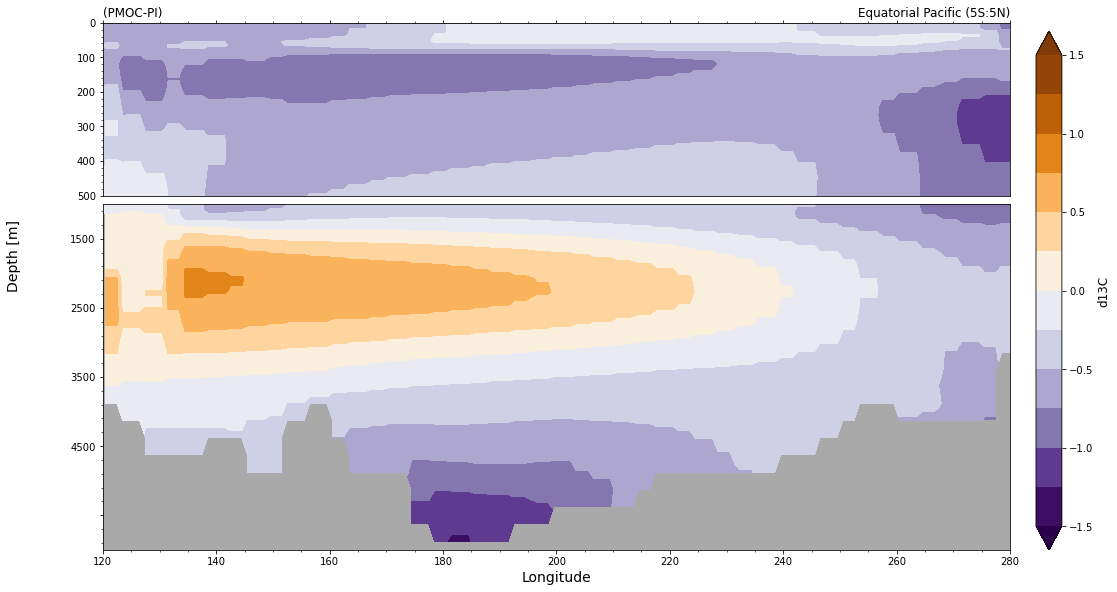

In [30]:
lo = -1.5
hi = 1.5
dc = 0.25
cnlevels = np.arange(lo, hi+dc, dc)

## create a figure object
fig = plt.figure(figsize=(18, 12))

## add two axes
ax1 = fig.add_axes([0.1, 0.51, 0.7, 0.2]) # top 500 m
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.4]) # deep ocean

## set the background color for land
ax1.set_facecolor('darkgray')
ax2.set_facecolor('darkgray')

## plot the model d13C by looping over axes
cs = [None]*2
mesh = [None]*2  
for i, ax in enumerate([ax1, ax2]):
    mesh[i] = ax.contourf(PMOC_d13C_time_avg_reg.lon,PMOC_d13C_time_avg_reg.z_t*1e-2,
                          Eq_Pac_d13C_Anomaly,levels=cnlevels,cmap='PuOr_r',extend='both')  
    
## set axis limits, note the reversed limits reverse the y-axis
ax1.set_ylim([500., 0.])
ax2.set_ylim([5500., 500.])
ax1.set_xlim([120, 280])
ax2.set_xlim([120, 280])
    
## set top axis properties
ax1.minorticks_on()
ax1.set_xticklabels([])
ax1.xaxis.set_ticks_position('top')

## set bottom axis properties
ax2.minorticks_on()
ax2.xaxis.set_ticks_position('bottom')
ax2.set_xticklabels(np.arange(120,300,20))  
ax2.set_yticklabels(np.arange(500,5500,1000))

## set plot-level axis labels via ax2
ax2.set_ylabel('Depth [m]',fontsize=14)
ax2.yaxis.set_label_coords(-0.09, 0.85)  
ax2.set_xlabel('Longitude',fontsize=14)

## set colorbar properties    
colorbar_axes = plt.gcf().add_axes([0.82, 0.1, 0.02, 0.6])
colorbar = plt.colorbar(mesh[i], colorbar_axes, orientation='vertical')
colorbar.set_label('%s' % 'd13C',size=12)

## title
ax1.set_title('(PMOC-PI)',loc='left')
ax1.set_title('Equatorial Pacific (5S:5N)',loc='right');

plt.rcParams['pdf.fonttype']=42
fig.savefig('Goldschmidt_d13C_Eq_Pac_PMOC_PI_anomaly.pdf', dpi=300, bbox_inches='tight')

# Site-Specific Depth Profiles 

In [32]:
## Time Averages

PMOC_temp_time_avg=PMOC_temp.mean(dim='time').compute()
PMOC_d13C_time_avg=PMOC_d13C.mean(dim='time').compute()
#PMOC_BASIN_MASK_time_avg=PMOC_BASIN_MASK.mean(dim='time').compute()

In [33]:
#### Regrid to 1x1

## Rename Axes
PMOC_temp_time_avg=PMOC_temp_time_avg.rename({'TLONG': 'lon', 'TLAT': 'lat'})
PMOC_d13C_time_avg=PMOC_d13C_time_avg.rename({'TLONG': 'lon', 'TLAT': 'lat'})

## Create new grid
new_lat=np.arange(-89.5,90.5,1)
new_lon=np.arange(0.5,360,1)

ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                    'lon': (['lon'], new_lon)})

## Regrid
regridder = xe.Regridder(PMOC_temp_time_avg, ds_out,'nearest_s2d')
PMOC_temp_time_avg_reg = regridder(PMOC_temp_time_avg)

regridder = xe.Regridder(PMOC_d13C_time_avg, ds_out,'nearest_s2d')
PMOC_d13C_time_avg_reg = regridder(PMOC_d13C_time_avg)

### Site 851

In [34]:
## Local Slice
PMOC_temp_851=PMOC_temp_time_avg_reg.sel(lat=2.77,lon=249.43,method='nearest')
PMOC_d13C_851=PMOC_d13C_time_avg_reg.sel(lat=2.77,lon=249.43,method='nearest')

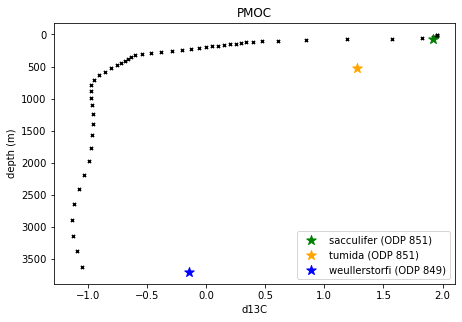

In [35]:
## Create Figure Object
fig = plt.figure(figsize=(7.2, 4.8))

x = [1.92]
y = [75]  ## keep the depth prescribed by temperature
x2 = [1.28]
y2 =[528]
x3 = -0.14 ## site 849
y3 = 3700 ## benthic depth
color='black'
plt.scatter(PMOC_d13C_851,PMOC_d13C_851.z_t*1e-2,marker='x',s=10,c=color)
plt.scatter(x, y, marker='*',color='green',s=100,label='sacculifer (ODP 851)')
plt.scatter(x2, y2, marker='*',color='orange',s=100,label='tumida (ODP 851)')
plt.scatter(x3, y3, marker='*',color='blue',s=100,label='weullerstorfi (ODP 849)')


plt.gca().invert_yaxis()
#plt.xlim(-1.5,1.5)
#plt.ylim(200,0)
plt.xlabel('d13C')
plt.ylabel('depth (m)')
plt.legend()
plt.title('PMOC')

plt.rcParams['pdf.fonttype']=42
fig.savefig('profile_851_d13C_PMOC.pdf', dpi=300, bbox_inches='tight')

### Site 872

In [36]:
## Local Slice
PMOC_temp_872=PMOC_temp_time_avg_reg.sel(lat=10.05,lon=162.5,method='nearest')
PMOC_d13C_872=PMOC_d13C_time_avg_reg.sel(lat=10.05,lon=162.5,method='nearest')

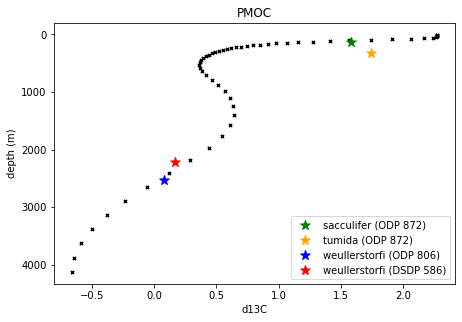

In [37]:
## Create Figure Object
fig = plt.figure(figsize=(7.2, 4.8))

x = [1.58]
y = [125]  ## keep the depth prescribed by temperature
x2 = [1.74]
y2 =[327]
x3 = 0.08 ## site 806
y3 = 2531 ## benthic depth
x4 = 0.17 ## site 586
y4 = 2208 ## benthic depth
     
color='black'
plt.scatter(PMOC_d13C_872,PMOC_d13C_872.z_t*1e-2,marker='x',s=10,c=color)
plt.scatter(x, y, marker='*',color='green',s=100,label='sacculifer (ODP 872)')
plt.scatter(x2, y2, marker='*',color='orange',s=100,label='tumida (ODP 872)')
plt.scatter(x3, y3, marker='*',color='blue',s=100,label='weullerstorfi (ODP 806)')
plt.scatter(x4, y4, marker='*',color='red',s=100,label='weullerstorfi (DSDP 586)')

plt.gca().invert_yaxis()
#plt.xlim(-1.5,1.5)
#plt.ylim(200,0)
plt.xlabel('d13C')
plt.ylabel('depth (m)')
plt.legend()
plt.title('PMOC')

plt.rcParams['pdf.fonttype']=42
fig.savefig('profile_872_d13C_PMOC.pdf', dpi=300, bbox_inches='tight')

### Site 292

In [38]:
## Local Slice
PMOC_temp_292=PMOC_temp_time_avg_reg.sel(lat=15.5,lon=124.4,method='nearest')
PMOC_d13C_292=PMOC_d13C_time_avg_reg.sel(lat=15.5,lon=124.4,method='nearest')

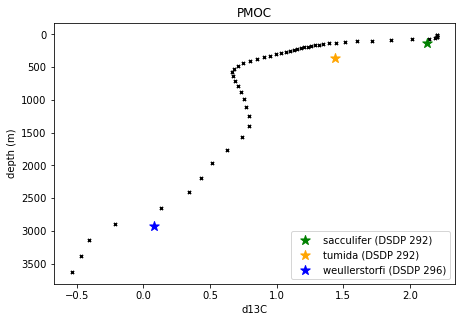

In [39]:
## Create Figure Object
fig = plt.figure(figsize=(7.2, 4.8))

x = [2.13]
y = [125]  ## keep the depth prescribed by temperature
x2 = [1.44]
y2 =[365]
x3 = 0.08 ## site 296
y3 = 2920 ## benthic depth
     
color='black'
plt.scatter(PMOC_d13C_292,PMOC_d13C_292.z_t*1e-2,marker='x',s=10,c=color)
plt.scatter(x, y, marker='*',color='green',s=100,label='sacculifer (DSDP 292)')
plt.scatter(x2, y2, marker='*',color='orange',s=100,label='tumida (DSDP 292)')
plt.scatter(x3, y3, marker='*',color='blue',s=100,label='weullerstorfi (DSDP 296)')

plt.gca().invert_yaxis()
#plt.xlim(-1.5,1.5)
#plt.ylim(200,0)
plt.xlabel('d13C')
plt.ylabel('depth (m)')
plt.legend(loc='lower right')
plt.title('PMOC')

plt.rcParams['pdf.fonttype']=42
fig.savefig('profile_292_3.2Ma_d13C_PMOC.pdf', dpi=300, bbox_inches='tight')